# fMRI-04 Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

This notebook provides an overview of reading, manipulating, and saving fMRI data in python.

## Part 1: The Python fMRI Ecosystem

Traditionally, fMRI researchers have relied on one of several software libraries for performing fMRI analysis. Packages such as SPM (Matlab, UCL), FSL (C/python, Oxford), AFNI (C, NIMH), and Freesurfer (C/Matlab, MGH) were and still are the major workhouses for fMRI analysis. As the field of fMRI analysis has advanced (and as the wider fMRI community has grown more computationally savvy), there's been an increasing push to centralize and standardize tools and incorporate fMRI analysis into larger analytic workflows.

Unsurprisingly then, there's been a collosal effort to move fMRI analysis into the python ecosystem (and also R). The most prominent example of this is [NIPY](https://nipy.org/), a constellation of python packages for (f)MRI preprocessing and analysis including:

- [nipype](https://nipype.readthedocs.io/en/latest/): a pythonic interface to existing neuroimaging software (and basis for fmriprep)
- [nibabel](https://nipy.org/nibabel/): provides read/write access to some common neuroimaging file formats
- [nitime](http://nipy.org/nitime/): time-series analysis of data from neuroscience experiments
- [nilearn](https://nilearn.github.io/): statistical learning on neuroimaging data
- [pymvpa](http://www.pymvpa.org/): machine learning for neuroimaging data
- [mindboggle](https://mindboggle.info/): automated labeling and shape analysis of human brain image data 
- [mne](http://martinos.org/mne/stable/index.html): software for m/eeg data analysis
- [pysurfer](https://pysurfer.github.io/): visualizing cortical surface representations of neuroimaging data

In the tutorials below, we will be covering only the basic functions available across these libraries. We encourage you to check some of them out though. To note, there are number of other great up-and-coming MRI packages in python that we will not be covering but want to earmark:

- [brainiak](https://brainiak.org/): advanced fMRI analyses in Python
- [fitlins](https://github.com/poldracklab/fitlins): automated first-level analysis through fmriprep
- [lyman](https://github.com/mwaskom/lyman): python port of FSL
- [FIRdeconvolution](https://github.com/tknapen/FIRDeconvolution): deconvolution algorithms for timeseries data
- [neurodesign](https://github.com/neuropower/neurodesign): tools for fMRI experimental design and power analysis

## Part 2: Reference Frames

As if fMRI analysis was not convoluted enough already, we first need to have a conversation about reference spaces before moving onto analysis. Whereas before we talked about temporal reference frames (e.g. scanner time vs. human time), now we'll discuss spatial reference frames. 

Over the course of fMRI preprocessing, the functional data is usually spatially transformed into another reference space. This gives us a range of analysis options presented in the table below:

| Space  | Native | Standardized |
|--------|--------|--------------|
| Volume | Native | MNI 152/302  |
| Surface| Native | fsaverage    |

The important dichotomies to note are *native* vs. *standardized* and *volume* vs. *surface*. The distinction between native and standardized is an important one. Native space analysis specifies that the data remains in alignment to actual topography of the participant's brain; in other words, the data reflects all of the idiosynchrasies of one particular human brain. This is in contrast to standardized space, where a participant's data has been realigned to a common atlas (typically MNI 302). In this latter case, the spatial arrangement of the data may no longer reflect accurately reflect the participant's anatomy (e.g. the voxels corresponding to visual cortex may no longer perfectly overlap with the participant's anatomical scan). The advatange is that the common space may be easier to interpret, work with, and combine with other data.

The second distinction is between volume- and surface-based analysis. Volume-based analysis treats the brain as the data is collected: in three dimensions. In volumetric analysis, we are still dealing with voxels and *Euclidean* distance. Volume-based analysis is appropriate for the subcortex which has a homogenous 3d organization. In contrast, surface-based analysis treats the cortical surface as what it is: as two-dimensional sheets of tissue (e.g. gyri and sulci). In surface-based analysis, we consider geodesic distances. To note, there are standardized reference frames for the cortical surface too (e.g. *fsaverage*). 

There are various advantages and disadvantages to analyzing data in each of these spaces (e.g. fewer vs. more transformations, interpretability of structures, biological accuracy), but for present purposes any is ok for this class insofar that we keep track of what space we are in. 

## Part 3: Working with Volume (3d) Data

### Reading / Writing Volume Data
Reading in MRI data is easy with `nibabel`. For a more complete tutorial, see [here](https://nipy.org/nibabel/gettingstarted.html).

In [2]:
import nibabel as nib

## Load anatomical data.
obj = nib.load('T1.nii.gz')

Nibabel objects store many useful pieces of information, including the data, the affine transformation, and the header.

In [3]:
## Show header.
print(obj.header.keys()[:10])

['sizeof_hdr', 'data_type', 'db_name', 'extents', 'session_error', 'regular', 'dim_info', 'dim', 'intent_p1', 'intent_p2']


Extracting data is similarly easy.

(76, 76, 93)


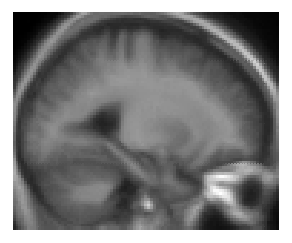

In [4]:
## Extract data.
data = obj.get_data()
print(data.shape)

## Visualize one slide.
sns.heatmap(data[50], cmap='binary_r', square=True, cbar=False, 
            xticklabels=[], yticklabels=[]);

Saving data is also easy. Whenever we save data, we must also store its associated affine transformation (otherwise we will not know how to interpret its spatial reference frame).

In [5]:
## Store data as Nifti image.
nifti = nib.Nifti1Image(data, obj.affine)

## Save data.
# nib.save(nifti, 'example.nii.gz')

### Masking Volume Data

Because MRI data are just NumPy arrays, masking data is simply an indexing problem. Below, we demonstrate masking with the brainmask and with an anatomical atlas.

#### Brainmask

(76, 76, 93)


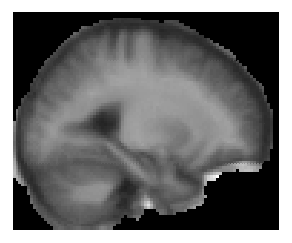

In [6]:
## Load brainmask.
mask = nib.load('brainmask.nii.gz').get_data()
print(mask.shape)

## Make copy of data.
copy = data.copy()

## Mask out nonbrain.
copy[mask == 0] = 0

## Visualize one slide.
sns.heatmap(copy[50], cmap='binary_r', square=True, cbar=False, 
            xticklabels=[], yticklabels=[]);

#### Freesurfer aseg
The labels corresponding to each ROI were found using the Freesurfer [color lookup table](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT).

(76, 76, 93)


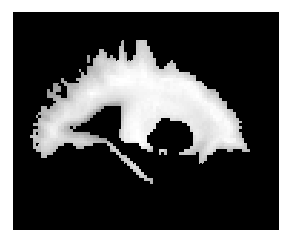

In [7]:
## Load brainmask.
aseg = nib.load('aseg.nii.gz').get_data()
print(aseg.shape)

## Make copy of data.
copy = data.copy()

## Mask out all but left hemisphere white matter.
copy[aseg != 2] = 0.

## Visualize one slide.
sns.heatmap(copy[50], cmap='binary_r',square=True, cbar=False, 
            xticklabels=[], yticklabels=[]);

## Part 4: Working with Surface (2d) Data

### Reading / Writing Surface Data
Reading in MRI data is easy with `nibabel`. For a more complete tutorial, see [here](https://nipy.org/nibabel/gettingstarted.html).

In [8]:
## Load surface data.
obj = nib.load('surface-lh.nii.gz')

## Extract data.
data = obj.get_data()
print(data.shape)

## Store data as Nifti image.
nifti = nib.Nifti1Image(data, obj.affine)

## Save data.
# nib.save(nifti, 'example.nii.gz')

(10242, 1, 1, 1)


## Masking Surface Data

Masks in surface space are known as labels. Labels are simply a collection of vertices associated with a particular region of interest. We will use `mne` to read in an exampe label.

In [9]:
from mne import read_label

## Load V1 label.
label = read_label('V1-lh.label')
print(label.vertices.size)

## Limit data to V1.
v1 = data[label.vertices]
print(v1.shape)

543
(543, 1, 1, 1)
